In [ ]:
### Usage within repository

In [1]:
import sys
sys.path.append('../../../')

### Mount Google drive when using Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Usage with Python wheel (e.g. when using Google Colab)

In [29]:
pip install ../../../artefacts/bilevel_optimisation-1.0.0-py3-none-any.whl

Processing /home/florianthaler/Documents/research/bilevel_optimisation/artefacts/bilevel_optimisation-1.0.0-py3-none-any.whl
bilevel-optimisation is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [3]:
from bilevel_optimisation.dataset.ImageDataset import TestImageDataset
from bilevel_optimisation.utils.DatasetUtils import collate_function
from bilevel_optimisation.utils.ConfigUtils import load_app_config
from bilevel_optimisation.data.ParamSpec import ParamSpec
from bilevel_optimisation.data.OptimiserSpec import OptimiserSpec
from bilevel_optimisation.energy import OptimisationEnergy
from bilevel_optimisation.evaluation.Evaluation import compute_psnr
from bilevel_optimisation.utils.SetupUtils import set_up_regulariser, set_up_measurement_model
from bilevel_optimisation.utils.SetupUtils import set_up_inner_energy

### Setup regulariser (load filter and filter weights from file)

In [4]:
custom_config_dir_path = 'example_prediction_I'
app_name = 'bilevel_optimisation'
configuring_module = '[DENOISING] predict'
config = load_app_config(app_name, custom_config_dir_path, configuring_module)

### Setup image dataset

In [5]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
test_data_root_dir = '/home/florianthaler/Documents/data/image_data/some_images'
test_image_dataset = TestImageDataset(root_path=test_data_root_dir, dtype=dtype)
test_loader = DataLoader(test_image_dataset, batch_size=len(test_image_dataset), shuffle=False,
                         collate_fn=lambda x: collate_function(x, crop_size=-1))

### Setup regulariser

In [7]:
regulariser = set_up_regulariser(config, device)
regulariser = regulariser.to(device=device, dtype=dtype)

### Setup measurement model and inner energy

In [8]:
test_batch = list(test_loader)[0]
test_batch_ = test_batch.to(device=device, dtype=dtype)

measurement_model = set_up_measurement_model(test_batch_, config)
energy = set_up_inner_energy(measurement_model, regulariser, config)

### Denoise

In [9]:
t0 = time.time()
test_batch_denoised = energy.argmin(energy.measurement_model.obs_noisy)
t1 = time.time()

print('denoising stats:')
print(' > elapsed time [s] = {:.5f}'.format(t1 - t0))

denoising stats:
 > elapsed time [s] = 28.52662


 > psnr [dB] = 29.36677


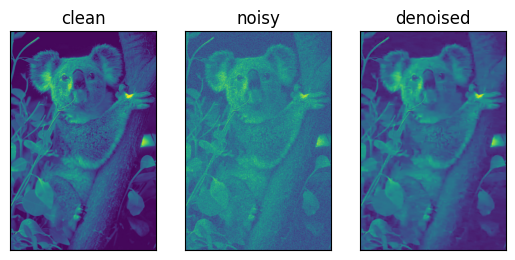

 > psnr [dB] = 29.13452


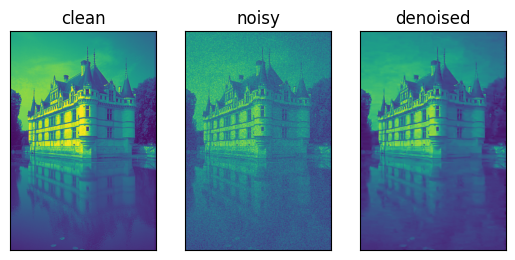

In [10]:
u_clean_splits = torch.split(test_batch_, split_size_or_sections=1, dim=0)
u_noisy_splits = torch.split(energy.measurement_model.obs_noisy, split_size_or_sections=1, dim=0)
u_denoised_splits = torch.split(test_batch_denoised, split_size_or_sections=1, dim=0)
for idx, (item_clean, item_noisy, item_denoised) in (
        enumerate(zip(u_clean_splits, u_noisy_splits, u_denoised_splits))):
    psnr = compute_psnr(item_clean, item_denoised)
    print(' > psnr [dB] = {:.5f}'.format(psnr.detach().cpu().item()))

    fig = plt.figure()
    ax_clean = fig.add_subplot(1, 3, 1)
    ax_clean.imshow(item_clean.squeeze().detach().cpu().numpy())
    ax_clean.set_title('clean')
    ax_clean.xaxis.set_visible(False)
    ax_clean.yaxis.set_visible(False)

    ax_noisy = fig.add_subplot(1, 3, 2)
    ax_noisy.imshow(item_noisy.squeeze().detach().cpu().numpy())
    ax_noisy.set_title('noisy')
    ax_noisy.xaxis.set_visible(False)
    ax_noisy.yaxis.set_visible(False)

    ax_denoised = fig.add_subplot(1, 3, 3)
    ax_denoised.imshow(item_denoised.squeeze().detach().cpu().numpy())
    ax_denoised.set_title('denoised')
    ax_denoised.xaxis.set_visible(False)
    ax_denoised.yaxis.set_visible(False)
    plt.show()
